In [2]:
import polars as pl
import os

DATA_PATH = os.getenv("DATA_PATH")

### Create model instance

In [3]:
from pathlib import Path
import polars as pl
from farcaster_sybil_detection.config.defaults import Config
from farcaster_sybil_detection.services.detector import DetectorService
from farcaster_sybil_detection.features.registry import FeatureRegistry
from farcaster_sybil_detection.features.extractors.content_engagement_extractor import (
    ContentEngagementExtractor,
)
from farcaster_sybil_detection.features.extractors.network_analysis_extractor import (
    NetworkAnalysisExtractor,
)
from farcaster_sybil_detection.features.extractors.temporal_behavior_extractor import (
    TemporalBehaviorExtractor,
)
from farcaster_sybil_detection.features.extractors.user_identity_extractor import (
    UserIdentityExtractor,
)

pl.Config.set_streaming_chunk_size(1_000_000)
pl.Config.set_fmt_str_lengths(50)

config = Config(
    data_path=Path(f"{DATA_PATH}/raw"),
    checkpoint_dir=Path(f"checkpoints"),
    model_dir=Path(f"{DATA_PATH}/models"),
)

registry = FeatureRegistry()

# Register in any order - manager will figure out correct build order
registry.register("user_identity", UserIdentityExtractor)
registry.register("network_analysis", NetworkAnalysisExtractor)
registry.register("temporal_behavior", TemporalBehaviorExtractor)
registry.register("content_engagement", ContentEngagementExtractor)
# registry.register("reputation_meta", ReputationMetaExtractor)

detector = DetectorService(config, registry)

/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-09 12:00:08,137 - DetectorService - DEBUG - Loading existing model from checkpoint.


### Train model

In [ ]:
# labels = pl.read_parquet(f"{DATA_PATH}/interim/labels.parquet")
# detector.train(labels)


### Compute ML result for all data in checkpoints

In [4]:
checkpoints_fids = []
for file in os.listdir("checkpoints"):
  if "network_analysis_filtered_" not in file:
    continue
  df = pl.read_parquet(f"checkpoints/{file}")
  checkpoints_fids += df["fid"].to_list()
  print(file, len(df))

network_analysis_filtered_5292248519603798795.parquet 695308
network_analysis_filtered_-7342865693725668243.parquet 5048
network_analysis_filtered_800890766114431589.parquet 199739


In [6]:
X = detector.feature_manager.build_feature_matrix(checkpoints_fids)

2025-01-09 12:00:08,712 - FeatureManager - DEBUG - Starting feature matrix build - Memory usage: 508.80 MB
2025-01-09 12:00:08,761 - FeatureManager - DEBUG - Base FIDs: 900095
/Users/jean/bleu/farcaster-social-graph/farcaster-sybil-detection/farcaster_sybil_detection/features/manager.py:166: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  f"Feature matrix schema: {feature_matrix.schema} ({len(feature_matrix.columns)} columns)"
/Users/jean/bleu/farcaster-social-graph/farcaster-sybil-detection/farcaster_sybil_detection/features/manager.py:166: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  f"Feature matrix schema: {feature_matrix.schema} ({len(feature_matrix.columns)} columns)"
2025-01-09 12

In [7]:
X

fid,cast_count,reply_count,mention_count,avg_cast_length,link_usage_rate,content_type_diversity,content_complexity,total_reactions,like_count,recast_count,engagement_rate,viral_coefficient,audience_reach,engagement_consistency,conversation_depth,conversation_initiation_rate,thread_participation,content_originality,vocabulary_richness,hashtag_usage,casts_with_mentions,avg_mentions_per_cast,mention_frequency,emoji_spam_ratio,price_mention_ratio,symbol_spam_ratio,airdrop_term_ratio,follow_ratio,network_growth_rate,follow_velocity,network_age_hours,growth_stability,follower_growth_rate,following_growth_rate,follow_reciprocity,network_density,…,has_avatar,has_display_name,profile_completeness,display_name_length,bio_length,fname_random_numbers,fname_wallet_pattern,fname_excessive_symbols,fname_airdrop_terms,fname_has_year,bio_random_numbers,bio_wallet_pattern,bio_excessive_symbols,bio_airdrop_terms,bio_has_year,fname_entropy,bio_entropy,total_verifications,eth_verifications,verification_consistency,platforms_verified,verification_span_days,avg_hours_between_verifications,platform_diversity,verification_velocity,sequential_verifications,verification_gaps,storage_units,storage_utilization,storage_update_frequency,storage_growth_rate,storage_stability,storage_efficiency,identity_strength,verification_quality,profile_authenticity,resource_utilization
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
255609,2281.0,1429.0,0.0,23.233231,0.138097,0.690815,0.0,5331.0,3002.0,2329.0,7.155705,0.436797,0.724832,5.366496,762.7637,0.37352,1.0,0.613766,7.915757,0.138097,214,0.120561,0.093819,0.002192,0.001315,0.0,0.245068,0.999212,0.0,221.227761,7485.0,222.320121,0.0,0.0,1.0,1.0,…,1,1,0.75,4.0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.363636,5.428571,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.3,0.0,0.8,0.7
2236,234.0,152.0,0.0,58.029915,0.08547,0.80232,0.0,1280.0,1178.0,102.0,1.01992,0.079625,0.325896,5.366496,74.410256,0.350427,1.0,0.944444,7.915757,0.08547,35,0.222222,0.149573,0.0,0.07265,0.0,0.179487,0.997658,0.0,9.441489,19324.0,318.637921,0.0,0.0,1.0,1.0,…,1,1,0.75,12.0,91,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.4,0.413043,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,0.3,0.0,1.0,0.7
714129,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.986667,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,…,1,1,0.75,11.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.083333,9.5,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.3,0.0,1.0,0.7
658680,23.0,0.0,0.0,104.521739,0.0,0.783736,0.0,10.0,10.0,0.0,0.149254,0.0,0.149254,5.366496,0.0,1.0,1.0,1.0,7.915757,0.0,1,0.043478,0.043478,0.0,0.086957,0.0,0.0,0.991228,0.0,3.624284,3496.0,130.362365,0.0,0.0,1.0,1.0,…,1,1,0.75,11.0,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.625,1.1875,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.3,0.0,1.0,0.7
686991,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,…,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
191112,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,…,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2
36305,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [9]:
print("Total rows:", len(X))

# Check rows with infinites
with_inf = X.filter(pl.any_horizontal(pl.all().is_infinite()))
print("Rows with infinites:", len(with_inf))

# Check rows without infinites
without_inf = X.filter(~pl.col("fid").is_in(with_inf["fid"]))
print("Rows without infinites:", len(without_inf))

Total rows: 900095
Rows with infinites: 145034
Rows without infinites: 755061
Sum of filtered rows: 900095
Sum of rows matching infinite condition: shape: (1, 1)
┌────────┐
│ fid    │
│ ---    │
│ u32    │
╞════════╡
│ 145034 │
└────────┘


In [ ]:
model = detector.predictor.model
y = model.predict_proba(without_inf[model.feature_names])

/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without

[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787690009884803
[LightGBM] [Warning] bagging_fraction is set=0.9470844703487703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470844703487703
[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787690009884803
[LightGBM] [Warning] bagging_fraction is set=0.9470844703487703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470844703487703
[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787690009884803
[LightGBM] [Warning] bagging_fraction is set=0.9470844703487703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470844703487703
[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ign

/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without

[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787690009884803
[LightGBM] [Warning] bagging_fraction is set=0.9470844703487703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470844703487703
[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787690009884803
[LightGBM] [Warning] bagging_fraction is set=0.9470844703487703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470844703487703
[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9787690009884803
[LightGBM] [Warning] bagging_fraction is set=0.9470844703487703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9470844703487703
[LightGBM] [Warning] feature_fraction is set=0.9787690009884803, colsample_bytree=1.0 will be ign

In [19]:
y[:,1]

array([0.9913744 , 0.28883509, 0.08167649, ..., 0.03785443, 0.03785443,
       0.03785443])

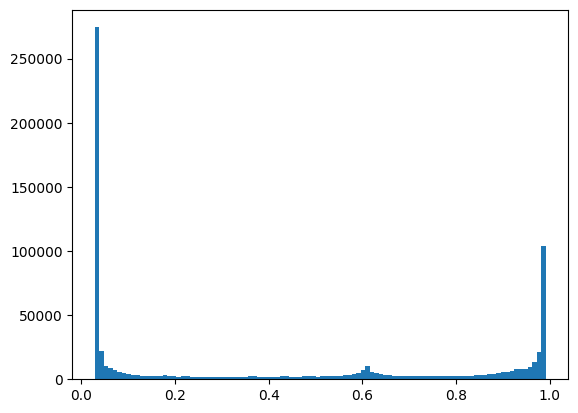

In [20]:
import matplotlib.pyplot as plt

plt.hist(y[:,1],bins=100)
plt.show()

### Create a results dataframe

In [21]:
results = pl.DataFrame({
    "fid":without_inf["fid"].to_list(),
    "ml_proba":y[:,1]
  },{
    "fid":pl.Int64,"ml_proba":pl.Float64
  })

In [22]:
results

fid,ml_proba
i64,f64
255609,0.991374
2236,0.288835
658680,0.081676
686991,0.037852
229391,0.037624
…,…
191112,0.037854
36305,0.037854
178137,0.037854


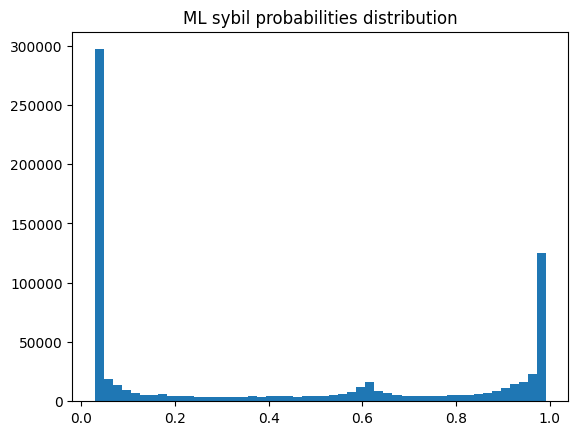

In [55]:
import matplotlib.pyplot as plt
plt.hist(results["ml_proba"],bins=50)
plt.title("ML sybil probabilities distribution")
plt.show()

In [24]:
fnames = pl.read_parquet(f"{DATA_PATH}/raw/farcaster-fnames-0-1730134800.parquet")
last_fnames = fnames[["fid","updated_at"]].group_by("fid").max()
last_fnames = last_fnames.join(fnames,on=["fid","updated_at"],how="left",coalesce=True)[["fid","fname"]]

labels = pl.read_parquet(f"{DATA_PATH}/interim/labels.parquet")

In [25]:
results = results.join(last_fnames,how="left",on="fid",coalesce=True)
results

fid,ml_proba,fname
i64,f64,str
255609,0.991374,"""regiranger"""
2236,0.288835,"""amin"""
658680,0.081676,"""thane0n"""
686991,0.037852,null
229391,0.037624,"""waffeletten"""
…,…,…
191112,0.037854,null
36305,0.037854,null
178137,0.037854,null


### Ensemble with sybilscar

In [26]:
import numpy as np

sybilscar_results = pl.read_parquet(f"{DATA_PATH}/interim/sybil_scar_results.parquet")
sybilscar_results = sybilscar_results.with_columns(np.ones(len(sybilscar_results))-pl.col("posterior").alias("sybilscar_proba"))
sybilscar_results

fid_index,posterior,fid,sybilscar_proba
i64,f64,i64,f64
184830,0.0,610208,1.0
96628,0.0,192804,1.0
294716,0.0,748147,1.0
178313,1.0,246616,0.0
240437,0.0,769577,1.0
…,…,…,…
365426,0.0,669904,1.0
56598,0.0,593844,1.0
103020,0.0,624311,1.0


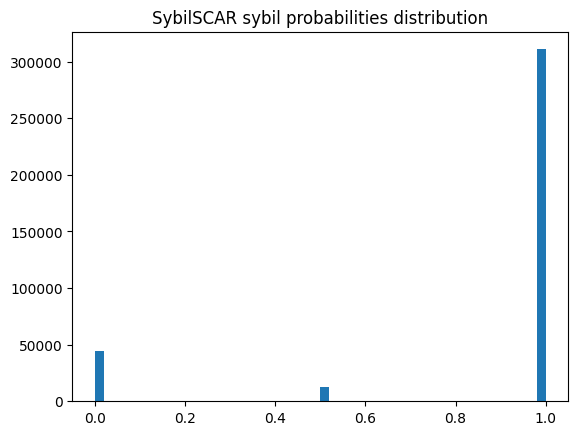

In [54]:
import matplotlib.pyplot as plt
plt.hist(sybilscar_results["sybilscar_proba"],bins=50)
plt.title("SybilSCAR sybil probabilities distribution")
plt.show()

In [27]:
all_results = results.join(sybilscar_results[["fid","sybilscar_proba"]],how="left",on="fid",coalesce=True)
all_results

fid,ml_proba,fname,sybilscar_proba
i64,f64,str,f64
255609,0.991374,"""regiranger""",1.0
2236,0.288835,"""amin""",0.0
658680,0.081676,"""thane0n""",1.0
686991,0.037852,null,null
229391,0.037624,"""waffeletten""",null
…,…,…,…
191112,0.037854,null,null
36305,0.037854,null,null
178137,0.037854,null,null


In [28]:
SYBIL_THRESHOLD = 0.8
BENIGN_THRESHOLD = 0.2

ensemble_predictions = all_results.with_columns(
  pl.when(pl.col('sybilscar_proba').is_null() & pl.col('ml_proba').is_null())
    .then(None)
    .when(pl.col('ml_proba').is_null())
    .then(pl.col('sybilscar_proba'))
    .when(pl.col('sybilscar_proba').is_null())
    .then(pl.col('ml_proba'))
    .otherwise((pl.col('sybilscar_proba') + pl.col('ml_proba')) / 2)
    .alias('sybil_probability')
)

ensemble_predictions = ensemble_predictions.with_columns(
  pl.when(pl.col('sybil_probability').is_null())
    .then(None)
    .when(pl.col('sybil_probability')>SYBIL_THRESHOLD)
    .then(True)
    .when(pl.col('sybil_probability') <= BENIGN_THRESHOLD)
    .then(False)
    .otherwise(None)
    .alias('sybil_diagnosis')
)

ensemble_predictions

fid,ml_proba,fname,sybilscar_proba,sybil_probability,sybil_diagnosis
i64,f64,str,f64,f64,bool
255609,0.991374,"""regiranger""",1.0,0.995687,true
2236,0.288835,"""amin""",0.0,0.144418,false
658680,0.081676,"""thane0n""",1.0,0.540838,null
686991,0.037852,null,null,0.037852,false
229391,0.037624,"""waffeletten""",null,0.037624,false
…,…,…,…,…,…
191112,0.037854,null,null,0.037854,false
36305,0.037854,null,null,0.037854,false
178137,0.037854,null,null,0.037854,false


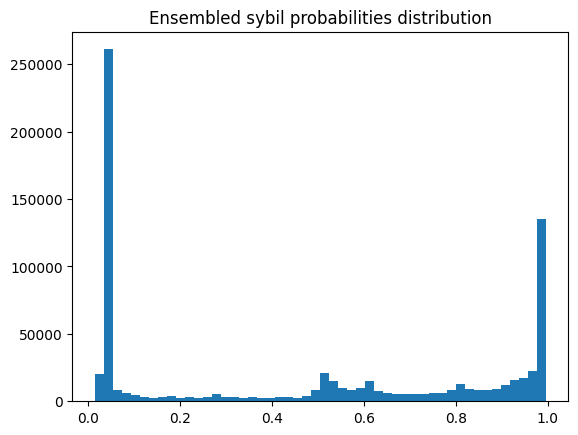

In [56]:
import matplotlib.pyplot as plt
plt.hist(ensemble_predictions["sybil_probability"],bins=50)
plt.title("Ensembled sybil probabilities distribution")
plt.show()

In [29]:
ensemble_predictions["sybil_diagnosis"].is_null().sum()

191125

### Join with all farcaster fids

In [30]:
all_fids = pl.read_parquet(f"{DATA_PATH}/raw/farcaster-fids-0-1734496500.parquet")
all_fids

created_at,updated_at,custody_address,registered_at,fid
datetime[ns],datetime[ns],binary,"datetime[ns, UTC]",i64
2023-10-13 15:07:21.731280,2024-06-05 18:09:02.020,"b""\xb3\x97\x15\x8b\\xb5\x02\x03\xa5\x91j\x07\x12U)\xb1I\xca\xe3<""",2023-11-07 20:38:19 UTC,42796
2023-10-13 15:07:21.732119,2024-06-05 18:09:02.024,"b""\xed\x93\xe1\xef\x7f+\xef\x9c\x94\x9a\xa1\xba\xca\xa8\x9c\x10\xae\xae\x1b\xac""",2023-11-07 20:38:19 UTC,42797
2023-10-13 15:07:21.734257,2024-06-05 18:09:02.025,"b""\xf6\x9bv\x99\xd2/\xb1\x87z6\x10\xef\x81\xe9{\x05\x20\x03\xc5\xac""",2023-11-07 20:38:19 UTC,42798
2023-10-13 15:32:07.129182,2024-06-05 18:10:59.760,"b""\xa1-f\x16\x8e\x88\x18\xe8-hS\x1d_c\x09\xe6\x07/\xc8\xf5""",2023-11-07 20:49:51 UTC,64737
2023-10-13 15:53:45.836242,2024-06-05 18:12:26.055,"b""\x0f\xc9\x11\xd1S\xbd\xb0*<p;\xd6RG\xb2\x80\xd8\xe6Y\x85""",2023-11-07 20:57:45 UTC,80519
…,…,…,…,…
2024-12-18 04:30:43.618925,2024-12-18 04:30:43.618925,"b""\xeb\x88\x93?O\xe6\x06\x94\xf6n\xe4\x88\xb2/d1\xd1f\xb5\xda""",2024-12-18 04:30:35 UTC,904313
2024-12-18 04:30:51.695587,2024-12-18 04:30:51.695587,"b""\xcb\xb3.\x8cU~\xec<\x13T\xa2\xb5]\x90\xff\xf5\xdbS\xc7\xe3""",2024-12-18 04:30:45 UTC,904314
2024-12-18 04:30:51.696297,2024-12-18 04:30:51.696297,"b""g\x11\xb0\x910\x0b\x11\xd7Q\x98\xb8@\xd4]\x81\xcb\xf7\xd5\xe3\xd9""",2024-12-18 04:30:47 UTC,904315


In [31]:
df = all_fids[["fid"]].join(
  ensemble_predictions[["fid","fname","sybil_probability","sybil_diagnosis"]],
  on="fid",
  how="left",
  coalesce=True
)
df

fid,fname,sybil_probability,sybil_diagnosis
i64,str,f64,bool
42796,null,0.037854,false
42797,null,0.037854,false
42798,null,0.037854,false
64737,null,0.037854,false
80519,null,0.037854,false
…,…,…,…
904313,null,null,null
904314,null,null,null
904315,null,null,null


### Post it in database

In [49]:
from prisma import Prisma

async def bulk_update_sybil_probabilities(df: pl.DataFrame, batch_size: int = 1000, super_batch_size: int = 10000):
    try:
        # Convert all FIDs to integers
        fids = [int(fid) for fid in df['fid']]
        
        # Convert DataFrame to records list
        records = [
            {
                "fid": int(row["fid"]),
                "fname": row["fname"],
                "sybilProbability": float(row["sybil_probability"]) if row.get("sybil_probability") is not None else None,
                "sybilDiagnosis": bool(row["sybil_diagnosis"]) if row.get("sybil_diagnosis") is not None else None,
            }
            for row in df.to_dicts()
        ]
        
        # Process in super batches
        for super_i in range(0, len(fids), super_batch_size):
            # Connect prisma for this super batch
            prisma = Prisma()
            await prisma.connect()
            
            try:
                super_batch_fids = fids[super_i:super_i + super_batch_size]
                super_batch_records = records[super_i:super_i + super_batch_size]
                
                # Delete records in smaller batches within this super batch
                for i in range(0, len(super_batch_fids), batch_size):
                    batch_fids = super_batch_fids[i:i + batch_size]
                    await prisma.sybilprobability.delete_many(
                        where={
                            'fid': {'in': batch_fids}
                        }
                    )
                    print(f"Deleted batch {(super_i + i)//batch_size + 1} of {(len(fids)-1)//batch_size + 1}")
                
                # Insert records in smaller batches within this super batch
                for i in range(0, len(super_batch_records), batch_size):
                    batch_records = super_batch_records[i:i + batch_size]
                    await prisma.sybilprobability.create_many(
                        data=batch_records
                    )
                    print(f"Inserted batch {(super_i + i)//batch_size + 1} of {(len(records)-1)//batch_size + 1}")
            
            finally:
                # Disconnect after each super batch
                await prisma.disconnect()
                print(f"Completed super batch {super_i//super_batch_size + 1} of {(len(fids)-1)//super_batch_size + 1}")
    
    except Exception as e:
        print(f"Error occurred: {e}")
        raise e

In [40]:
df

fid,fname,sybil_probability,sybil_diagnosis
i64,str,f64,bool
42796,null,0.037854,false
42797,null,0.037854,false
42798,null,0.037854,false
64737,null,0.037854,false
80519,null,0.037854,false
…,…,…,…
904313,null,null,null
904314,null,null,null
904315,null,null,null


In [50]:
await bulk_update_sybil_probabilities(df, batch_size=30_000, super_batch_size=300_000)

Deleted batch 1 of 31
Deleted batch 2 of 31
Deleted batch 3 of 31
Deleted batch 4 of 31
Deleted batch 5 of 31
Deleted batch 6 of 31
Deleted batch 7 of 31
Deleted batch 8 of 31
Deleted batch 9 of 31
Deleted batch 10 of 31
Inserted batch 1 of 31
Inserted batch 2 of 31
Inserted batch 3 of 31
Inserted batch 4 of 31
Inserted batch 5 of 31
Inserted batch 6 of 31
Inserted batch 7 of 31
Inserted batch 8 of 31
Inserted batch 9 of 31
Inserted batch 10 of 31
Completed super batch 1 of 4
Deleted batch 11 of 31
Deleted batch 12 of 31
Deleted batch 13 of 31
Deleted batch 14 of 31
Deleted batch 15 of 31
Deleted batch 16 of 31
Deleted batch 17 of 31
Deleted batch 18 of 31
Deleted batch 19 of 31
Deleted batch 20 of 31
Inserted batch 11 of 31
Inserted batch 12 of 31
Inserted batch 13 of 31
Inserted batch 14 of 31
Inserted batch 15 of 31
Inserted batch 16 of 31
Inserted batch 17 of 31
Inserted batch 18 of 31
Inserted batch 19 of 31
Inserted batch 20 of 31
Completed super batch 2 of 4
Deleted batch 21 of 